# 05 - Model Tuning

Based on the model evaluations in the previous step, I have made adjustments to improve performance. I believe the best implementation of the logistic regression is the version trained on the full dataset. As for the random forest model, I am choosing the version trained on the dataset containing the top 20 most influential features because of the higher recall. In this step, I will be training an additional model, XGBoost, and optimizing all the models using hyperparameter tuning. I will also be implementing an ensemble model using the best versions of the other three models. By the end of this step, I will have 7 different models to compare. 

## Imports and Loading Data

I will be importing both versions of the dataset, since some models performed best on one and others performed best when trained on the other.

In [179]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from scipy.stats import randint, uniform

# Load Data
df_full = pd.read_csv('/Users/zulykathlucero/Desktop/predicting-employee-attrition/data/processed/features_full.csv')
df_top = pd.read_csv('/Users/zulykathlucero/Desktop/predicting-employee-attrition/data/processed/features_top20.csv')

## Splitting Data

I am splitting the data similarly to how I did in the last step, however, I am creating an alternate training data set using SMOTE. Our models' recall in the last step was underwhelming, and I believe that the class imbalance in our target variable is to blame. In order to improve recall, I am using SMOTE to create fake instances of employees who left the company. This alternate training dataset will only be used in the ensemble model implementation.

In [180]:
# Define Target
target = 'Attrition'

# Separate target from full dataset
X_full = df_full.drop(columns=target)
y_full = df_full[target]

# Separate target from filtered dataset
X_top = df_top.drop(columns=target)
y_top = df_top[target]

# 70/30 Split on both
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.3, random_state=42, stratify=y_full)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, test_size=0.3, random_state=42, stratify=y_top)

# Creating an SMOTE training dataset for the ensemble model
smote = SMOTE(random_state=42)
X_train_top_smote, y_train_top_smote = smote.fit_resample(X_train_top, y_train_top) # careful to only use SMOTE on the training data NOT on the testing

## Evaluation Method

To minimize reused code, I am creating a helper function that generates performance metrics for each model I create. This method uses 5-fold cross-validation to get a consistent and accurate measure of the models' performance. I am adding each model's metrics to a list to create tables and visualizations to compare the models. Once again, we are prioritizing recall, f1 score, and ROC AUC because of the class imbalance.

In [181]:
# Creating a list of dictionaries to store the performance metrics for each model
results = []

# Making sure to use cross-validated values to compare the models
def evaluate_model(name, model, X, y):
    recall = cross_val_score(model, X, y, cv=5, scoring='recall').mean()
    f1_score = cross_val_score(model, X, y, cv=5, scoring='f1').mean()
    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()

    results.append({
        'Model': name, 
        'Recall': recall,
        'F1 Score': f1_score,
        'ROC AUC': auc
    })


## Logistic Regression

To improve recall, I will be making some changes to this implementation of the Logistic Regression. I added class_weight='balanced' to this instance of the model to force the model to pay more attention to the minority class (employees who left the company) and increase recall. The hyperparameter tuning method I am using is GridSearchCV. I chose this method because the number of parameters to be tuned for this model is smaller and allows for a "brute force" method. I made sure to choose 'recall' as the scoring method for GridSearchCV to ensure it increases.

In [182]:
# Logistic Regression on Full Dataset
lr = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=5000, random_state=42) # Use liblinear solver to fix convergence warnings
lr.fit(X_train_full, y_train_full)

# Evaluate Model
evaluate_model("Logistic Regression Before", lr, X_full, y_full)

# Hypertuning the model
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid_lr, cv=5, scoring='recall') # prioritize recall
grid_lr.fit(X_train_full, y_train_full)
best_lr = grid_lr.best_estimator_ # Saving the best version of the model to use in the ensemble model

# Evaluate the model
evaluate_model("Tuned Logistic Regression", best_lr, X_full, y_full)

## Random Forest

Like the logistic regression, the Random Forest models also underperformed in recall. I will also be using class_weight='balanced' and  scoring='recall' to improve performance. I am only tuning a few hyperparameters on the Random Forest model, so I feel comfortable using GridSearchCV.

## XGBoost

Unlike the previous models, tuning XGBoost using GridSearchCV will be too computationally expensive because I am tuning with more hyperparameters. Therefore, I am choosing to use RandomizedSearchCV. In order to get this model to pay more attention to the minority class, I will have to set scale_pos_weight to the weight ratio of the target variable.

In [183]:
# Random Forest on Filtered Dataset
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42) # making sure the minority class is weighted higher
rf.fit(X_train_top, y_train_top)

# Evaluation Metrics
evaluate_model("Random Forest Before", rf, X_top, y_top)

# Hypertuning the model
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}
grid_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid_rf, cv=5, scoring='recall') # prioritizing recall
grid_rf.fit(X_train_top, y_train_top)
best_rf = grid_rf.best_estimator_ # Saving the best version of the model for the ensemble model

# Evaluate the Model
evaluate_model("Tuned Random Forest", best_rf, X_top, y_top)

In [184]:
# XGBoost on Filtered Dataset

# Calculating the weight ratio of the "Attrition" variable
neg, pos = np.bincount(y_top)
scale_pos_weight = neg / pos

xgboost = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42) # Using the weight ratio
xgboost.fit(X_train_top, y_train_top)

# Evaluate the Model
evaluate_model("XGBoost Before", xgboost, X_top, y_top)

# Hypertuning the Model
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'min_child_weight': randint(1, 10)
}

# Use RandomizedSearchCV on a new XGBoost model
xgb_clf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)

xgb_rand = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    scoring='recall', # prioritize recall
    n_iter=30,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the tuned model
xgb_rand.fit(X_top, y_top)
best_xgb = xgb_rand.best_estimator_ # saving the best version for the ensemble model

# Evaluate
evaluate_model("Tuned XGBoost", best_xgb, X_top, y_top)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


## Ensemble Modeling

Since these models seem to be performing poorly individually, combining them into one model might be more effective. I will be taking an extra step to improve recall for this model by using the SMOTE training set. I chose to use a soft voting technique to balance the performance metrics of the other three models.

In [185]:
# Retrain the best-tuned models on the SMOTE-resampled training set
best_lr.fit(X_train_top_smote, y_train_top_smote)
best_rf.fit(X_train_top_smote, y_train_top_smote)
best_xgb.fit(X_train_top_smote, y_train_top_smote)

# Creating ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='soft'  # Use 'soft' to average predicted probabilities
)

# Train and Evaluate
ensemble_model.fit(X_train_top_smote, y_train_top_smote)
y_pred_ens = ensemble_model.predict(X_test_top)
y_proba_ens = ensemble_model.predict_proba(X_test_top)[:, 1]

recall = recall_score(y_test_top, y_pred_ens)
f1 = f1_score(y_test_top, y_pred_ens)
roc_auc = roc_auc_score(y_test_top, y_proba_ens)

results.append({
    'Model': 'Ensemble Model',
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
})


## Comparing Models

Now that we have added 7 sets of performance metrics to the results table, we can compare the different models across recall, F1 score, and ROC AU (with a focus on recall). I have created a table to display the exact values and three bar graphs to easily compare the values across the different models.

In [186]:
# Creating a dataframe from the list
results_df = pd.DataFrame(results)
results_df

,Model,Recall,F1 Score,ROC AUC
0,Logistic Regression Before,0.730053,0.503427,0.836139
1,Tuned Logistic Regression,0.729965,0.504974,0.835023
2,Random Forest Before,0.206915,0.310652,0.755397
3,Tuned Random Forest,0.337943,0.413554,0.763678
4,XGBoost Before,0.363032,0.403903,0.753953
5,Tuned XGBoost,0.616223,0.473692,0.786950
6,Ensemble Model,0.591549,0.407767,0.752189


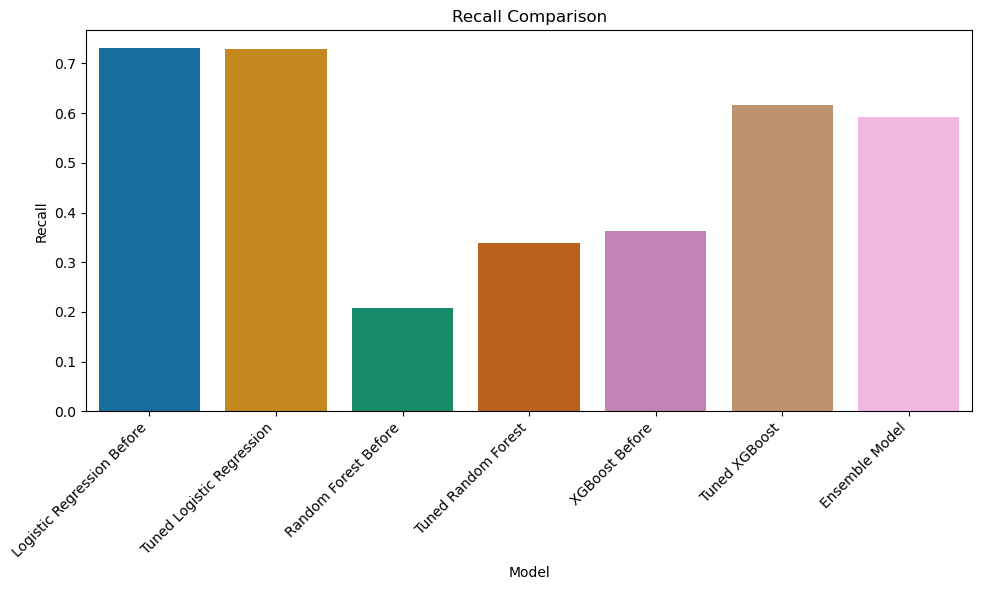

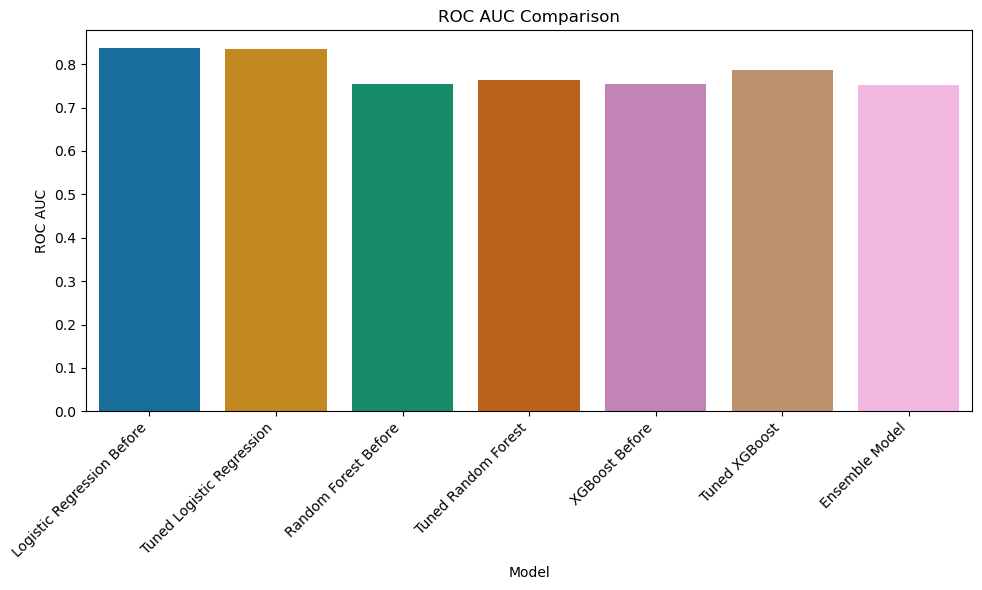

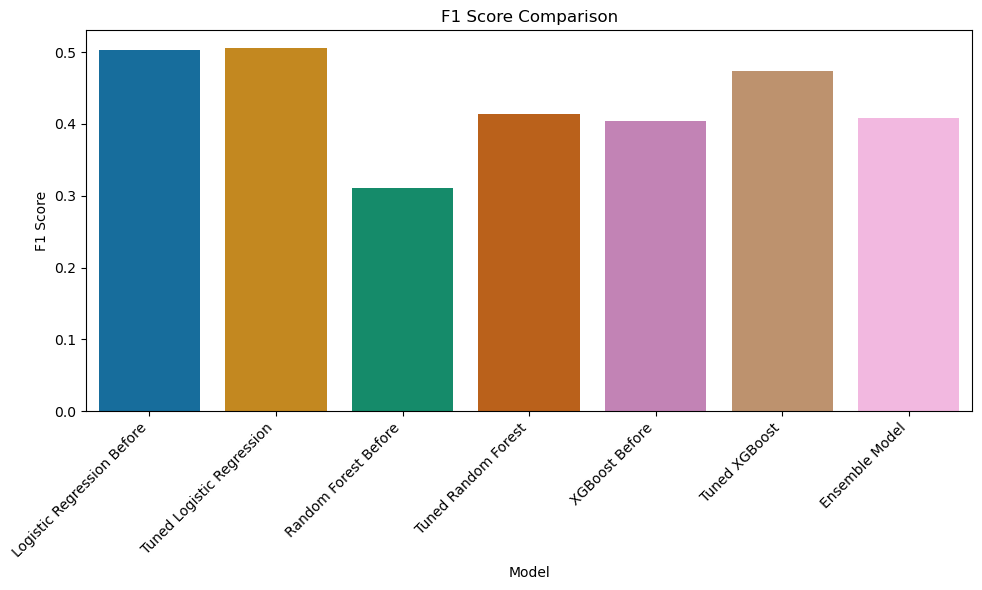

In [187]:
# Visualizing the difference in performance
metrics = ['Recall', 'ROC AUC', 'F1 Score']

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(data=results_df, x='Model', y=metric, hue='Model', palette='colorblind')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{metric} Comparison')
    plt.tight_layout()
    plt.savefig(f'/Users/zulykathlucero/Desktop/predicting-employee-attrition/reports/figures/{metric}_comparison_all.png')  # Save plots
    plt.show()

## Observations 

From the visualizations, we can see that the Logistic Regression, Random Forest, and XGBoost models all saw minor improvements from tuning. We can also see that the Logistic Regression models consistently outperformed the other models in all three metrics. While the performance gains from tuning Logistic Regression were minimal, it still achieved the highest recall, which aligns with the project’s goal of identifying employees at risk of attrition. We can also observe that the different methods used to improve recall (such as adjusting the class weight distribution of the models) contributed to a significant jump in recall across all models. The highest recall in the previous modeling step was around 0.405, while the highest recall in this step is around 0.73. I am choosing the Tuned Logistic Regression for further exploration because of it's high performance metrics and interpretable characteristics.